In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(cowplot)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/archaic-ychr
Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading ychr


In [2]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [3]:
times_df <- filter(
    tmrca_df,
    afr == "a00", 
    (arch == "mez2" & capture == "full") | (arch == "elsidron2" & capture == "lippold"),
    sites == "all",
    dp == 3,
    filt == "filt50"
) %>%
group_by(arch) %>%
summarise(tmrca = mean(tmrca_new)) %>%
mutate(age = c(44000, 49000))

times_df

arch,tmrca,age
<chr>,<dbl>,<dbl>
elsidron2,366586.4,44000
mez2,377946.1,49000


In [4]:
#' Get positions at which individual 'ind' is different from
#' a set of individuals in 'group' (including hg19) and merge
#' those genotypes with 'test' individual at those positions
#' - this is the individual for whom we want to calculate TMRCA
#' with ind.
get_differences <- function(test, ind, polarize_by, gt, mindp) {
    capture <- ifelse(str_detect(test, "elsidron2"), "lippold", "full")

    ## load genotypes of the test individual
    test_gt <- here(paste0("data/vcf/", capture, "_", test, ".vcf.gz")) %>%
        read_vcf(mindp = mindp, maxdp = 0.98) %>%
        filter(!is.na(!!sym(test))) # keep only sites with data

    ## subset the panel to the individuals of interest
    gt <- gt[, c("chrom", "pos", "REF", "ALT", ind, polarize_by)]
    ## keep fixed differences between a group of individuals
    ## and sample 'ind' (implicitly includes hg19 to 'polarize_by')
    freq <- gt[, polarize_by] %>% rowMeans
    differences <- filter(gt, !!sym(ind) == 1, freq == 0)

    ## join genotypes of the test individual at informative sites
    joined_gt <- inner_join(differences, test_gt, by = c("chrom", "pos", "REF")) %>%
        filter(complete.cases(.)) %>%
        select(-ALT.y) %>%
        rename(ALT = ALT.x)

    joined_gt
}

In [5]:
estimate_split <- function(test, from, gt, ancestral_ind,  mindp) {
  derived <- get_differences(test, from, ancestral_ind, gt, mindp)

  counts <- ifelse(derived[[test]] == 0, "ref", "alt") %>%
    factor(levels = c("ref", "alt")) %>%
    table %>%
    as.matrix %>%
    t %>%
    as.data.frame

  times <- filter(times_df, arch == from)

  ## simulate confidence intervals by sampling REF/ALT counts from Poisson
  sample_refs <- rpois(1000, counts$ref)
  sample_alts <- rpois(1000, counts$alt)
  tmrca_ci <- quantile(
    sample_refs / (sample_refs + sample_alts) * (times$tmrca - times$age) + times$age,
    c(0.025, 0.975),
    na.rm = T
  )

  counts %>%
    mutate(
      name = test,
      prop_ref = ref / (ref + alt),
      tmrca = prop_ref * (times$tmrca - times$age) + times$age,
      tmrca_low = tmrca_ci[1],
      tmrca_high = tmrca_ci[2],
      dp = mindp
    ) %>%
    select(name, everything())
}

## Neandertal lineage defined by _Mezmaiskaya 2_

In [6]:
all_mez2 %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = F, var_only = T)
nodmg_mez2 %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = T, var_only = T)

In [7]:
nrow(all_mez2)
nrow(nodmg_mez2)

[1] 220464

[1] 155303

In [8]:
targets <- c("spy1", "elsidron2", "shotgun_spy1", "spy1_merged", "shotgun_mez2", paste0("elsidron2_dp", 1:7))
ancestral_ind <- c("a00", "chimp", "S_French_1")

All SNPs:

In [9]:
tmrca_mez2_all <- map_dfr(1:3, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "mez2", all_mez2, ancestral_ind, mindp = dp))
}) %>% mutate(sites = "all")

Non C-T/G-A SNPs:

In [10]:
tmrca_mez2_nodmg <- map_dfr(1:3, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "mez2", nodmg_mez2, ancestral_ind, mindp = dp))
}) %>% mutate(sites = "nodmg")

In [11]:
tmrca_mez2 <- bind_rows(tmrca_mez2_all, tmrca_mez2_nodmg) %>%
    mutate(name = fix_name(name) %>% str_replace("^Spy 94a$", "Spy 94a (capture)"))

In [12]:
tmrca_mez2 %>% filter(dp == 1)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high,dp,sites
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Spy 94a (capture),67,410,0.140461216,95204.17,85211.06,105627.40,1,all
El Sidrón 1253 (560 kb),12,85,0.123711340,89694.36,69990.25,113188.96,1,all
Spy 94a (shotgun),58,357,0.139759036,94973.19,84185.61,105873.86,1,all
Spy 94a (merged),71,469,0.131481481,92250.32,82879.76,102061.75,1,all
Mezmaiskaya 2 (shotgun),3,595,0.005016722,50650.23,49000.00,52584.50,1,all
elsidron2_dp1,7,46,0.132075472,92445.71,64910.43,124506.19,1,all
elsidron2_dp2,12,63,0.160000000,101631.37,75667.72,129132.80,1,all
elsidron2_dp3,12,72,0.142857143,95992.30,72212.97,121216.53,1,all
elsidron2_dp4,11,81,0.119565217,88330.51,67469.96,111525.92,1,all


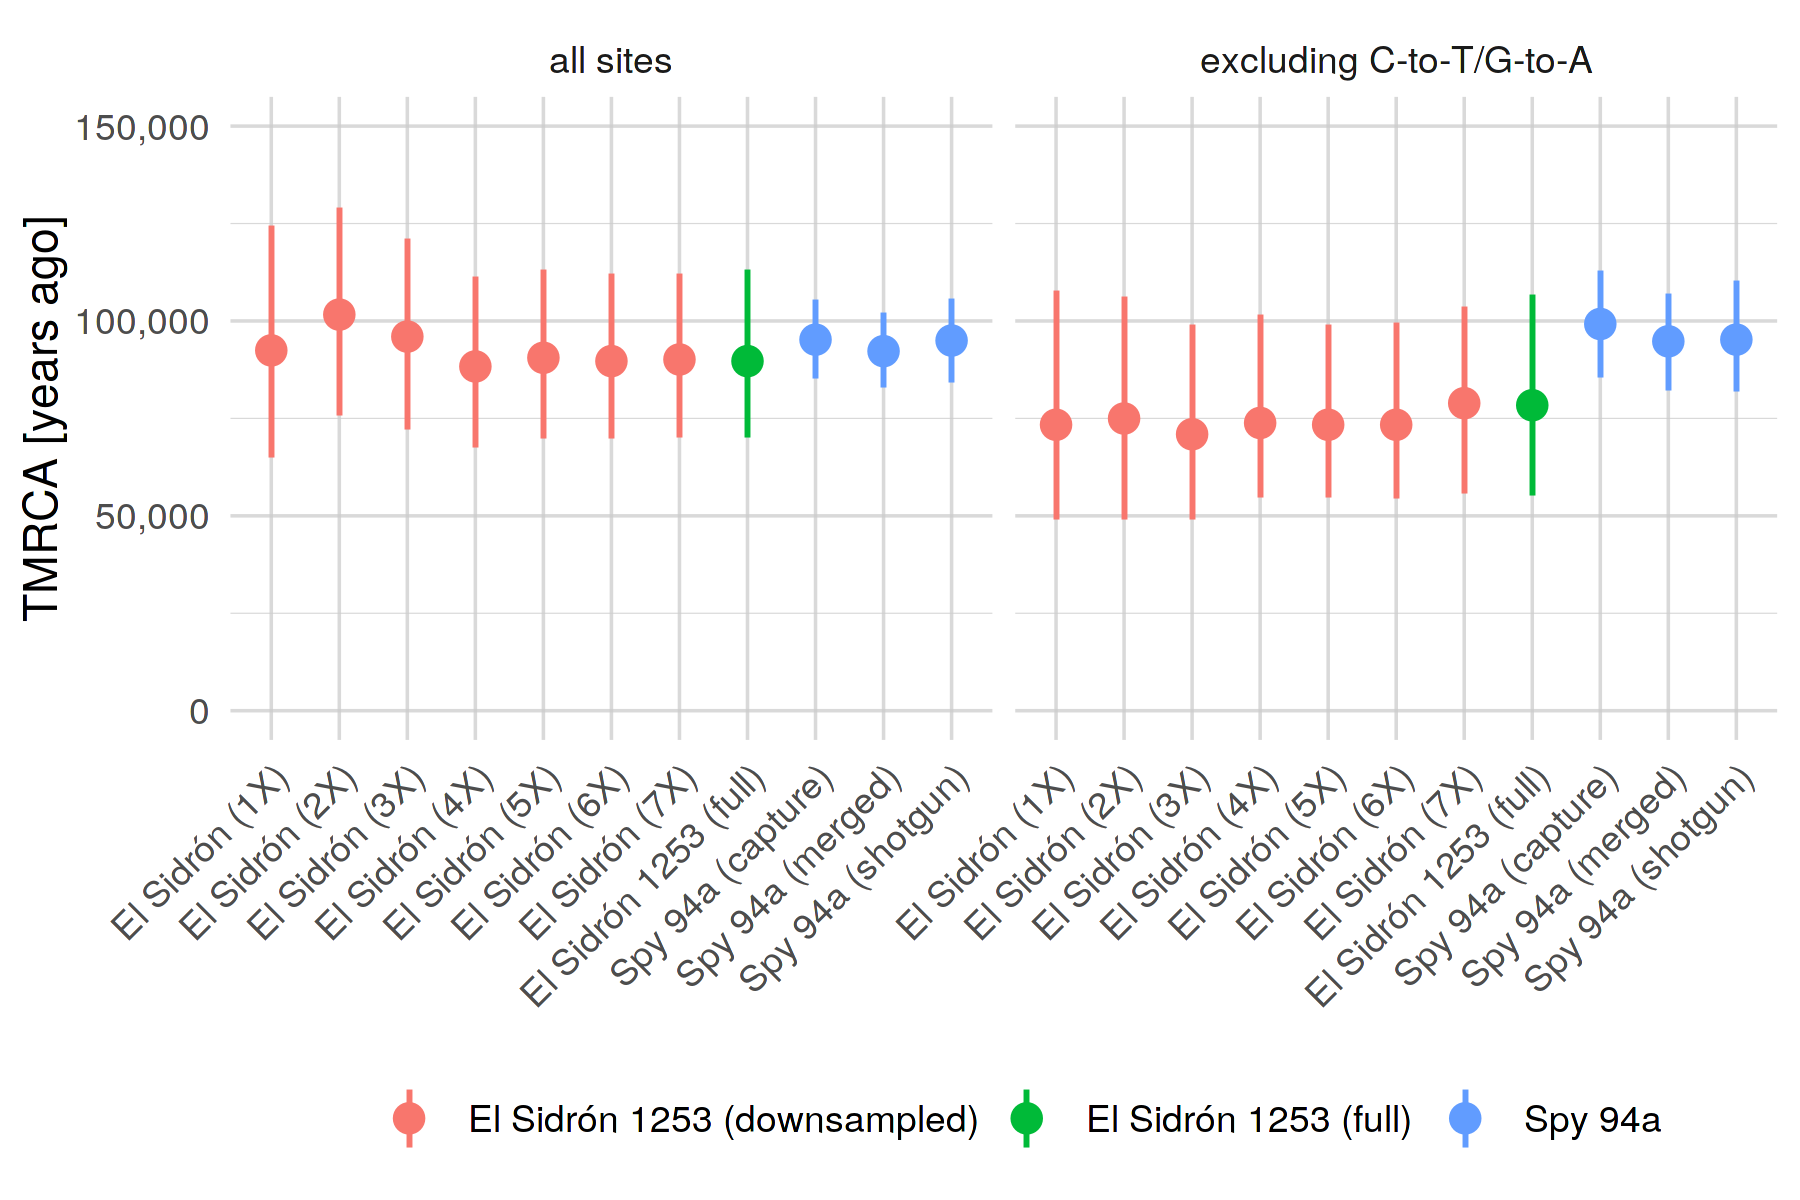

In [13]:
set_dim(6, 4)

tmrca_mez2 %>%
mutate(set = case_when(
    str_detect(name, "560 kb") ~ "El Sidrón 1253 (full)",
    str_detect(name, "elsidron2_dp") ~ "El Sidrón 1253 (downsampled)",
    TRUE ~ "Spy 94a"
)) %>%
mutate(name = str_replace(name, "elsidron2_dp(\\d)", "El Sidrón (\\1X)")) %>%
mutate(name = fix_name(name) %>% str_replace("560 kb", "full")) %>%
mutate(sites = ifelse(sites == "all", "all sites", "excluding C-to-T/G-to-A")) %>%
filter(!str_detect(name, "Mezmaiskaya"), dp == 1) %>%
ggplot(aes(name, tmrca)) +
    geom_pointrange(aes(name, tmrca, ymin = tmrca_low, ymax = tmrca_high, color = set)) +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    coord_cartesian(ylim = c(0, 150000)) +
    facet_wrap(~ sites) +
    theme_minimal() +
    theme(
        axis.title.x = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(hjust = 1, angle = 45)
    ) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    ylab("TMRCA [years ago]") +
    scale_y_continuous(labels = scales::comma) +
    guides(color = guide_legend(title = ""))

## Neandertal lineage defined by _Mezmaiskaya 2_

In [14]:
all_elsidron2 %<-% read_genotypes("elsidron2", "lippold", mindp = 1, maxdp = 0.98, nodmg = F, var_only = T)
nodmg_elsidron2 %<-% read_genotypes("elsidron2", "lippold", mindp = 1, maxdp = 0.98, nodmg = T, var_only = T)

In [15]:
nrow(all_elsidron2)
nrow(nodmg_elsidron2)

[1] 23185

[1] 16609

In [16]:
targets <- c("spy1", "mez2", "shotgun_spy1", "spy1_merged", "shotgun_mez2", paste0("mez2_dp", 1:9))
ancestral_ind <- c("a00", "chimp", "S_French_1")

All SNPs:

In [17]:
tmrca_elsidron2_all <- map_dfr(1:3, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "elsidron2", all_elsidron2, ancestral_ind, mindp = dp))
}) %>% mutate(sites = "all")

Non C-T/G-A SNPs:

In [18]:
tmrca_elsidron2_nodmg <- map_dfr(1:3, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "elsidron2", nodmg_elsidron2, ancestral_ind, mindp = dp))
}) %>% mutate(sites = "nodmg")

In [19]:
tmrca_elsidron2 <- bind_rows(tmrca_elsidron2_all, tmrca_elsidron2_nodmg) %>%
    mutate(name = fix_name(name) %>% str_replace("^Spy 94a$", "Spy 94a (capture)"))

In [39]:
tmrca_elsidron2 %>% filter(dp == 1)

name,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high,dp,sites
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Spy 94a (capture),32,28,0.5333333,216046.1,174164.16,254199.4,1,all
Mezmaiskaya 2,37,79,0.3189655,146893.9,121522.54,174411.3,1,all
Spy 94a (shotgun),24,23,0.5106383,208725.0,162489.08,259057.6,1,all
Spy 94a (merged),34,34,0.5000000,205293.2,168071.69,242867.0,1,all
Mezmaiskaya 2 (shotgun),17,40,0.2982456,140210.0,103738.22,179283.4,1,all
mez2_dp1,19,47,0.2878788,136865.8,100927.01,173057.0,1,all
mez2_dp2,26,62,0.2954545,139309.6,108517.28,169969.0,1,all
mez2_dp3,33,70,0.3203883,147352.9,116048.21,175318.4,1,all
mez2_dp4,31,74,0.2952381,139239.8,111912.92,169450.3,1,all


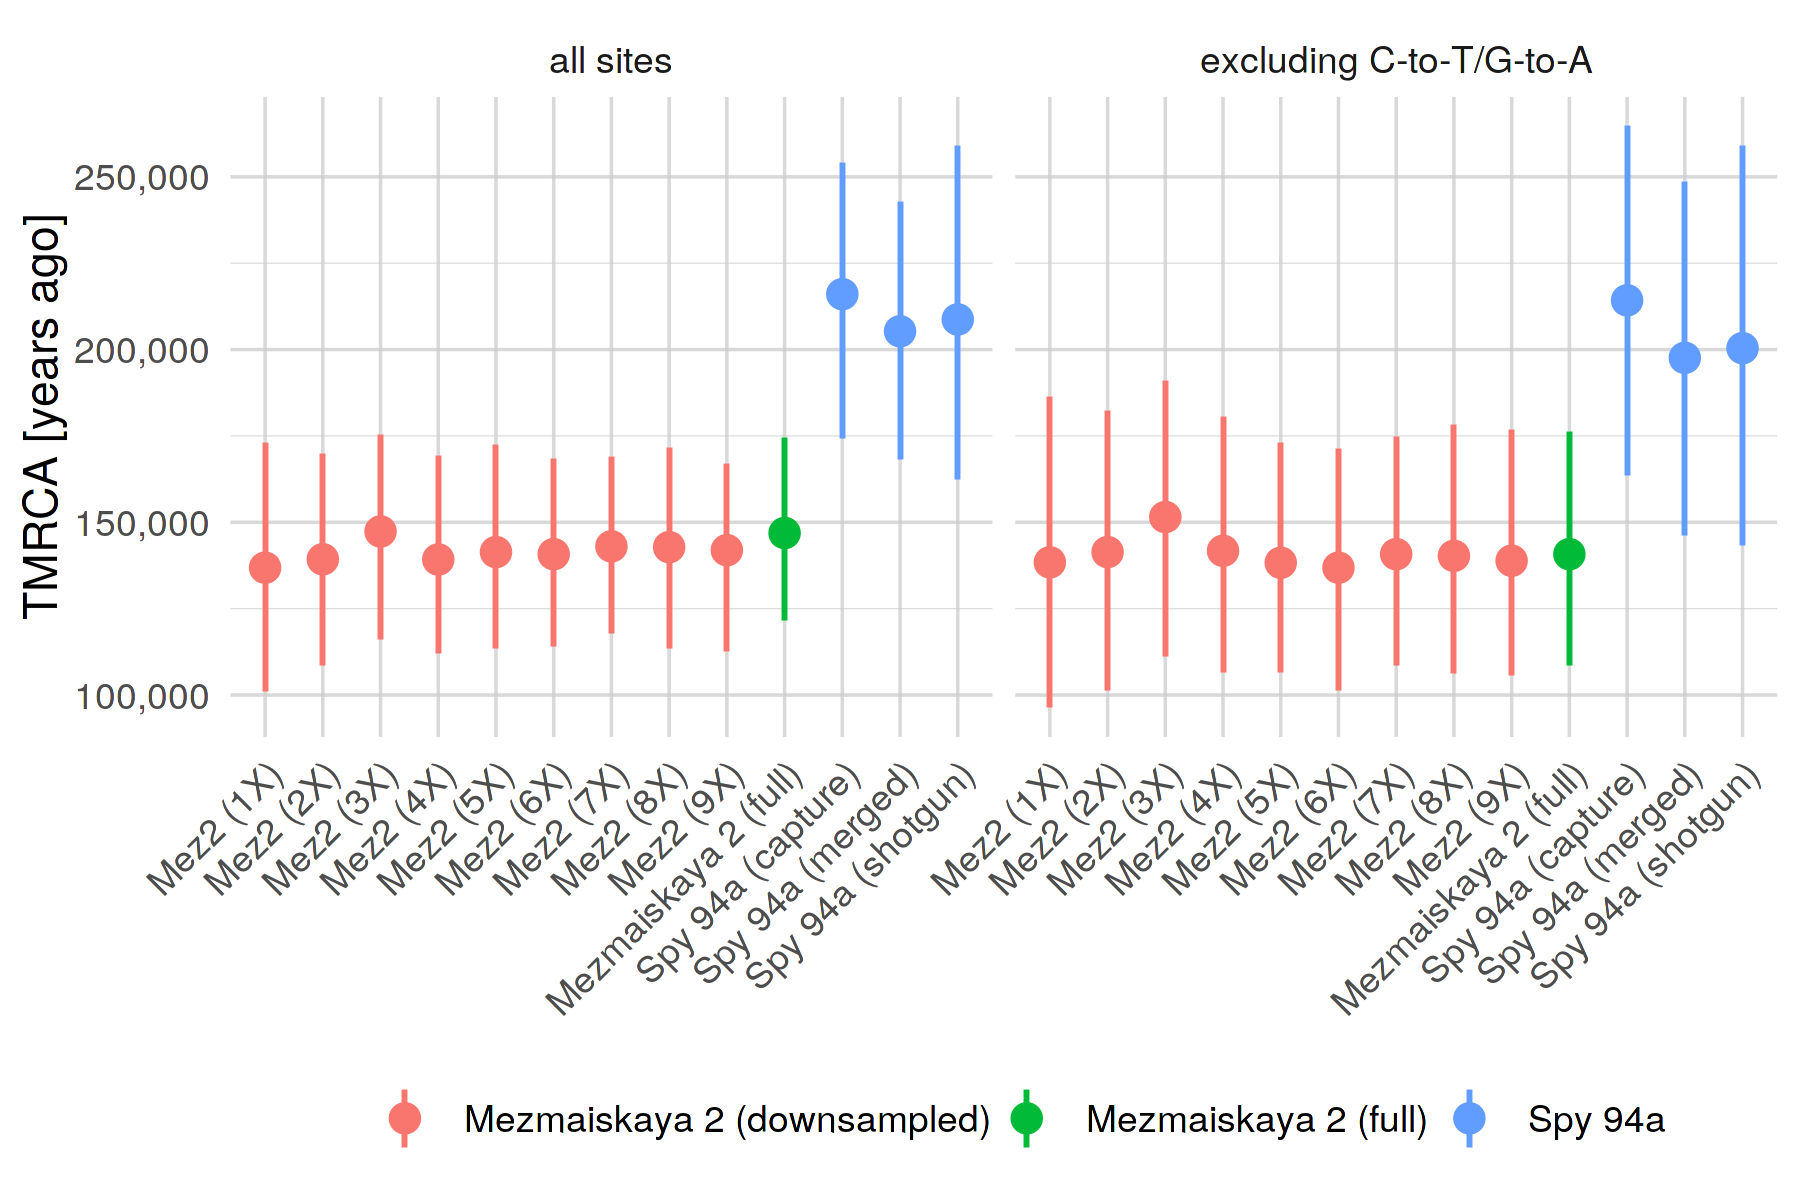

In [20]:
set_dim(6, 4)

tmrca_elsidron2 %>%
filter(name != "Mezmaiskaya 2 (shotgun)") %>% 
mutate(set = case_when(
    str_detect(name, "Mezmaiskaya 2") ~ "Mezmaiskaya 2 (full)",
    str_detect(name, "mez2_dp") ~ "Mezmaiskaya 2 (downsampled)",
    TRUE ~ "Spy 94a"
)) %>%
mutate(name = str_replace(name, "mez2_dp(\\d)", "Mez2 (\\1X)") %>%
       str_replace("Mezmaiskaya 2", "Mezmaiskaya 2 (full)")) %>%
mutate(sites = ifelse(sites == "all", "all sites", "excluding C-to-T/G-to-A")) %>%
filter(dp == 1) %>%
ggplot(aes(name, tmrca)) +
    geom_pointrange(aes(name, tmrca, ymin = tmrca_low, ymax = tmrca_high, color = set)) +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
#    coord_cartesian(ylim = c(0, 150000)) +
    facet_wrap(~ sites) +
    theme_minimal() +
    theme(
        axis.title.x = element_blank(),
        legend.position = "bottom",
        axis.text.x = element_text(hjust = 1, angle = 45)
    ) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    ylab("TMRCA [years ago]") +
    scale_y_continuous(labels = scales::comma) +
    guides(color = guide_legend(title = ""))

In [21]:
vcf_all_mez2      %<-% read_vcf(here("data/vcf/full_mez2.vcf.gz"),         mindp = 3, maxdp = 0.98)
vcf_all_elsidron2 %<-% read_vcf(here("data/vcf/lippold_elsidron2.vcf.gz"), mindp = 1, maxdp = 0.98)
vcf_all_spy1      %<-% read_vcf(here("data/vcf/full_spy1_merged.vcf.gz"),  mindp = 1, maxdp = 0.98)

In [22]:
vcf_all_mez2      <- filter(vcf_all_mez2,      !is.na(mez2))
vcf_all_elsidron2 <- filter(vcf_all_elsidron2, !is.na(elsidron2))
vcf_all_spy1      <- filter(vcf_all_spy1,      !is.na(spy1_merged))

In [23]:
gt_archaics <-
    full_join(vcf_all_mez2, vcf_all_elsidron2, by = c("chrom", "pos", "REF")) %>%
    full_join(vcf_all_spy1, by = c("chrom", "pos", "REF")) %>%
    rename(ALT_mez2 = ALT.x, ALT_elsidron2 = ALT.y, ALT_spy1 = ALT)

In [24]:
vcf_all_modern <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98, nodmg = F) %>%
    select(chrom, pos, REF, ALT, chimp, a00, S_French_1) %>%
    filter(chimp == 0, a00 == 0, S_French_1 == 0)

In [25]:
nrow(vcf_all_modern)

[1] 5974245

In [26]:
gt_all <- full_join(vcf_all_modern, gt_archaics, by = c("chrom", "pos", "REF")) %>% rename(ALT_modern = ALT)

In [27]:
diffs_all <- filter(gt_all, chimp == 0, a00 == 0, S_French_1 == 0, mez2 == 1) %>% rename(ALT = ALT_mez2)

In [28]:
nrow(diffs_all)

[1] 1133

In [29]:
summarise_at(diffs_all, vars(c("elsidron2", "spy1_merged")), ~ 1 - mean(., na.rm = T))

elsidron2,spy1_merged
<dbl>,<dbl>
0.1237113,0.1314815


In [30]:
vcf_nodmg_mez2      %<-% read_vcf(here("data/vcf/full_mez2.vcf.gz"),         mindp = 3, maxdp = 0.98, nodmg = T)
vcf_nodmg_elsidron2 %<-% read_vcf(here("data/vcf/lippold_elsidron2.vcf.gz"), mindp = 1, maxdp = 0.98, nodmg = T)
vcf_nodmg_spy1      %<-% read_vcf(here("data/vcf/full_spy1_merged.vcf.gz"),  mindp = 1, maxdp = 0.98, nodmg = T)

In [31]:
vcf_nodmg_mez2      <- filter(vcf_nodmg_mez2,      !is.na(mez2))
vcf_nodmg_elsidron2 <- filter(vcf_nodmg_elsidron2, !is.na(elsidron2))
vcf_nodmg_spy1      <- filter(vcf_nodmg_spy1,      !is.na(spy1_merged))

In [32]:
gt_nodmg_archaics <-
    full_join(vcf_nodmg_mez2, vcf_nodmg_elsidron2, by = c("chrom", "pos", "REF")) %>%
    full_join(vcf_nodmg_spy1, by = c("chrom", "pos", "REF")) %>%
    rename(ALT_mez2 = ALT.x, ALT_elsidron2 = ALT.y, ALT_spy1 = ALT)

In [33]:
vcf_nodmg_modern <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98, nodmg = T) %>%
    select(chrom, pos, REF, ALT, chimp, a00, S_French_1) %>%
    filter(chimp == 0, a00 == 0, S_French_1 == 0)

In [34]:
nrow(vcf_nodmg_modern)

[1] 5973229

In [35]:
gt_nodmg <- full_join(vcf_nodmg_modern, gt_nodmg_archaics, by = c("chrom", "pos", "REF")) %>% rename(ALT_modern = ALT)

In [36]:
diffs_nodmg <- filter(gt_nodmg, chimp == 0, a00 == 0, S_French_1 == 0, mez2 == 1) %>% rename(ALT = ALT_mez2)

In [37]:
nrow(diffs_nodmg)

[1] 651

In [38]:
summarise_at(diffs_nodmg, vars(c("elsidron2", "spy1_merged")), ~ 1 - mean(., na.rm = T))

elsidron2,spy1_merged
<dbl>,<dbl>
0.08928571,0.1391586
